In [7]:
# # prompt: get the drive connected to the notebook

# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import subprocess
import sys

def run_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()
    return output.decode(), error.decode()

# Install PyTorch with CUDA support
cmd = f"{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121"
output, error = run_command(cmd)
print("Output:", output)
print("Error:", error if error else "No errors")

Output: Looking in indexes: https://download.pytorch.org/whl/cu121

Error: No errors


In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [10]:
# !pip install torch torch_geometric transformers matplotlib sklearn

In [11]:
import torch
print(torch.__version__)
print(torch.version.cuda)  # Should return the CUDA version if available
print(torch.backends.cudnn.enabled)  # Should be True if CUDA is properly configured


2.5.1+cu121
12.1
True


if cuda version none - install pytorch with cuda

In [89]:
pip install -U scikit-learn


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 3.9 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.1 MB 6.6 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.1 MB 7.6 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.1 MB 8.2 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.1 MB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 8.9 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   -- ------------------------------------- 2.4/41.2 MB 12.2 MB/s eta 0:00:04
   ---- ----------------------------------- 4.7/41.2 MB 11.4 MB/s

# Installing and laoding cuda and othe packages

In [13]:
import torch
torch.cuda.is_available()

True

In [14]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


GPU is available. Using: NVIDIA GeForce RTX 3090


In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [16]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


# Loading dataset 

In [17]:
import os
import json
import torch
from torch_geometric.data import Data

def preprocess_object(obj, caption_text, tokenizer, device):
    """
    Converts a mesh object (obj) and caption_text into a graph data structure with a text embedding.
    """
    # Extract graph data (vertices, edges)
    vertices = torch.tensor(obj['v'], dtype=torch.float, device=device)
    edges = torch.tensor(obj['e'], dtype=torch.long, device=device).t()  # transpose edge_index

    print("Caption:", caption_text)

    # Encode text label using BERT with the provided tokenizer and model
    inputs = tokenizer(
        caption_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=32
    )
    input_ids = inputs["input_ids"].to(device=device, dtype=torch.long)

    with torch.no_grad():
        outputs = bert_model(input_ids)
    # Pool the embeddings: take the mean over the sequence dimension
    text_label_embedding = outputs.last_hidden_state.mean(dim=1)

    # Create a PyG Data object with node features, edge index, and text embedding
    graph_data = Data(
        x=vertices,
        edge_index=edges,
        text_label=text_label_embedding
    )
    return graph_data

def load_json_and_caption(json_file_path, tokenizer, device):
    """
    Loads the JSON data from json_file_path and locates the corresponding caption file.
    Returns a graph Data object.
    """
    # Read the JSON file
    with open(json_file_path, 'r') as f:
        obj = json.load(f)

    # Derive the base name from the JSON filename (e.g., 'model_id' from 'model_id.json')
    base_name = os.path.splitext(os.path.basename(json_file_path))[0]
    folder_path = os.path.dirname(json_file_path)

    # Attempt to find a caption file in the same folder (e.g., 'model_id_45_caption.txt')
    caption_text = ""
    for file_name in os.listdir(folder_path):
        if file_name.startswith(base_name) and file_name.endswith("_caption.txt"):
            caption_file_path = os.path.join(folder_path, file_name)
            with open(caption_file_path, 'r', encoding='utf-8') as cf:
                caption_text = cf.read().strip()
            break
            
    # Fallback: if no caption file is found, use obj['n'] if available
    if not caption_text:
        print(f"No matching caption file found for {base_name}, using obj['n'] if available.")
        caption_text = obj.get('n', '')

    return preprocess_object(obj, caption_text, tokenizer, device)

def create_dataset(root_folder, tokenizer, device, max_nodes=5000):
    """
    Iterates through subfolders in the root folder, loads JSON mesh data and caption files,
    and filters out any data points with more than max_nodes nodes.
    
    The folder structure is assumed to be:
      root_folder/
          model_id/
              model_id.json
              model_id_45_caption.txt
    """
    dataset = []

    # List all items in the root folder
    for model_id in os.listdir(root_folder):
        model_folder = os.path.join(root_folder, model_id)
        if os.path.isdir(model_folder):
            json_filename = f"{model_id}.json"
            json_path = os.path.join(model_folder, json_filename)
            
            if os.path.exists(json_path):
                data = load_json_and_caption(json_path, tokenizer, device)
                
                # Filter out data with more than max_nodes nodes
                num_nodes = data.x.size(0)
                print()
                if num_nodes > max_nodes:
                    print(f"Skipping {json_path} due to excessive nodes: {num_nodes} (max allowed {max_nodes}).")
                else:
                    dataset.append(data)
                    print(f"Loaded data from {json_path} with {num_nodes} nodes.")
            else:
                print(f"No JSON file found for {model_id} in {model_folder}. Skipping.")
        else:
            print(f"{model_id} is not a directory. Skipping.")

    return dataset

# Example usage:
# Make sure to initialize your tokenizer and BERT model appropriately:
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
# root_folder = "path/to/processed_models"
# dataset = create_dataset(root_folder, tokenizer, device, max_nodes=5000)


In [18]:
def filter_dataset_by_node_count(dataset, max_nodes=5000):
    """
    Filters the dataset to remove data points with more than max_nodes.
    
    Args:
        dataset (list): List of PyG Data objects.
        max_nodes (int): Maximum allowed number of nodes.
    
    Returns:
        list: A filtered dataset with data points having at most max_nodes.
    """
    filtered_dataset = [data for data in dataset if data.x.size(0) <= max_nodes]
    return filtered_dataset




In [19]:
# dataset = create_dataset("./processed_models")

In [20]:
# import os
# import json
# import torch
# from torch_geometric.data import Data

# def preprocess_object(obj, tokenizer=tokenizer, device=device):
#     # Extract graph data
#     vertices = torch.tensor(obj['v'], dtype=torch.float).to(device)  # Move to device
#     edges = torch.tensor(obj['e'], dtype=torch.long).t().to(device)  # Transpose and move to device

#     # Encode text label using BERT
#     text_label_str = obj['n']
#     inputs = tokenizer(text_label_str, return_tensors="pt", padding=True, truncation=True, max_length=32)
#     input_ids = inputs["input_ids"].to(dtype=torch.long)  # Ensure integer token IDs and move to device

#     with torch.no_grad():
#         outputs = bert_model(input_ids.to(device))  # Ensure input is on the correct device
#     text_label_embedding = outputs.last_hidden_state.to(device)  # Pool the embeddings and move to device
#     print(text_label_embedding.shape)
#     pooled_text_label = text_label_embedding.mean(dim=1)
#     # Create graph data
#     graph_data = Data(x=vertices, edge_index=edges, text_label=pooled_text_label)
    
#     print(graph_data)
#     return graph_data

# def load_json(file_path):
#     with open(file_path, 'r') as f:
#         data = json.load(f)

#         return preprocess_object(data)

# def create_dataset(folder_path):
#     dataset = []
#     file_list = os.listdir(folder_path)
#     print(len(file_list))
#     for file_name in file_list:
#         if file_name.endswith('.json'):
#             file_path = os.path.join(folder_path, file_name)
#             data = load_json(file_path)
#             dataset.append(data)
#             print(file_name)
#     return dataset

In [21]:
# Dataset and DataLoader
def load_data_and_split(folder_path,tokenizer,device ):
    dataset = create_dataset(folder_path,tokenizer,device)
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset

In [22]:
train_dataset, val_dataset, test_dataset = load_data_and_split('E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models',tokenizer,device)

Caption: The 3D model features a fuselage with a streamlined, elongated body. It includes two primary wings mounted at mid-body and a pair of stabilizing fins at the rear. The overall structure is aerodynamically shaped, facilitating efficient airflow.
Loaded data from E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models\10155655850468db78d106ce0a280f87\10155655850468db78d106ce0a280f87.json with 2645 nodes.
Caption: The 3D model features a streamlined fuselage with a pointed nose. It has two large wings extending laterally and a T-tail configuration at the rear. The body is elongated with a slight taper towards the tail, providing aerodynamic efficiency. Overall, the structure emphasizes functionality and stability.
Loaded data from E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models\1021a0914a7207aff927ed529ad90a11\1021a0914a7207aff927ed529ad90a11.json with 1333 nodes.
Caption: The 3D model features a streamlined fuselage with four wing-lik

In [25]:
filtered_dataset = filter_dataset_by_node_count(train_dataset, max_nodes=5000)
# Example usage:
print(f"Original dataset size: {len(train_dataset)}")
print(f"Filtered dataset size: {len(filtered_dataset)}")

Original dataset size: 1380
Filtered dataset size: 1380


In [26]:
filtered_dataset[3].x.size()

torch.Size([3546, 3])

In [77]:
filtered_dataset[1].edge_index


tensor([[   2,    9,   10,  ..., 4712, 4735, 4743],
        [   3,   10,   11,  ..., 4720, 4632, 4636]], device='cuda:0')

# Visualization

Vertices: 14382
Edges: 12354


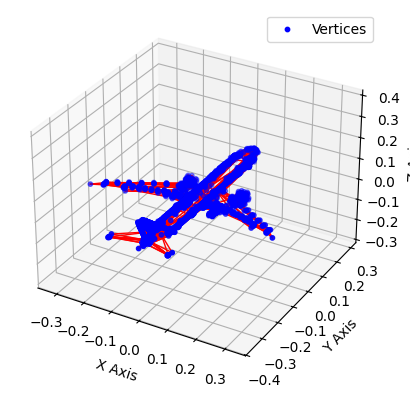

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize the 3D graph
def visualize_3d(vertices, edges):
    """
    Visualize a 3D graph given vertices and edges.

    :param vertices: numpy array of shape (n, 3) representing the 3D coordinates of the vertices.
    :param edges: numpy array of shape (2, m) where each column represents an edge (start_index, end_index).
    """
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ensure vertices are a numpy array
    vertices = np.array(vertices)

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', marker='o', s=10, label="Vertices")

    # Plot edges
    for i in range(edges.shape[1]):
        v1, v2 = edges[:, i]  # Each column represents an edge (start_index, end_index)
        ax.plot([vertices[v1, 0], vertices[v2, 0]],
                [vertices[v1, 1], vertices[v2, 1]],
                [vertices[v1, 2], vertices[v2, 2]], c='r', linewidth=1)

    # Set plot labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    # Set equal scaling for all axes
    max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                          vertices[:, 1].max() - vertices[:, 1].min(),
                          vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0

    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Display the plot
    plt.show()

# Extract vertices and edges from the dataset
vertices_np, edges_np, text_label = filtered_dataset[1].x.cpu().numpy(), filtered_dataset[1].edge_index.cpu().numpy(),filtered_dataset[1].text_label.cpu().numpy()

# Print the first graph's data for verification
print("Vertices:", vertices_np.size)
print("Edges:", edges_np.size)
# print("Text:", text_label)

# Visualize the first graph
visualize_3d(vertices_np, edges_np)


In [28]:
import torch.nn as nn

class NodeCountPredictor(nn.Module):
    def __init__(self, latent_dim):
        super(NodeCountPredictor, self).__init__()
        self.node_count_predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # Predict a single scalar
        )

    def forward(self, z):
        """
        Args:
            z: Latent representation [batch_size, latent_dim]
        Returns:
            predicted_node_count: Scalar prediction for the number of nodes
        """
        return self.node_count_predictor(z).squeeze(-1)

def pretrain_node_count_predictor(predictor, data_loader, optimizer, device, num_epochs=10):
    predictor.train()
    loss_fn = nn.MSELoss()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in data_loader:
            data = data.to(device)
            z = data.latent_vector  # Use precomputed latent vector
            true_num_nodes = data.num_nodes  # Ground truth node count
            
            # Forward pass
            predicted_num_nodes = predictor(z)
            
            # Compute loss
            loss = loss_fn(predicted_num_nodes, true_num_nodes.float())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(data_loader):.4f}")


# NodeCountPredictor()
# pretrain_node_count_predictor()

# Encoders

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

# Transformer Encoder
class TransformerTextEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerTextEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )

    def forward(self, text_input):
        """
        Args:
            text_input: Tensor of shape [batch_size, seq_len, embed_dim]
        Returns:
            encoded_text: Tensor of shape [batch_size, seq_len, embed_dim]
        """
        # Transpose to match Transformer input format: [seq_len, batch_size, embed_dim]
        text_input = text_input.permute(1, 0, 2)

        # Encode text
        encoded_text = self.transformer(text_input)  # Shape: [seq_len, batch_size, embed_dim]

        # Transpose back to [batch_size, seq_len, embed_dim]
        return encoded_text.permute(1, 0, 2)


# Graph Encoder (GNN)
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphEncoder, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.layers.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
        return x.mean(dim=0)  # Pooling to get latent feature z_G

# Feature Fusion
class FeatureFusion(nn.Module):
    def __init__(self, text_dim, graph_dim, fused_dim):
        super(FeatureFusion, self).__init__()
        self.fc = nn.Linear(text_dim + graph_dim, fused_dim)

    def forward(self, c_text, z_G):
        """
        Args:
            c_text: Encoded text from the Transformer [batch_size, seq_len, embed_dim]
            z_G: Encoded graph representation [batch_size, graph_dim]
        Returns:
            fused_features: Combined features [batch_size, fused_dim]
        """

        # Pool the sequence dimension of c_text
        c_text_pooled = c_text.mean(dim=1)  # Shape: [batch_size, text_dim]

        # Match dimensions of c_text and z_G
        if c_text_pooled.ndim == 2 and z_G.ndim == 1:
            z_G = z_G.unsqueeze(0).expand(c_text_pooled.size(0), -1)

        # Concatenate features and pass through the fully connected layer
        combined_features = torch.cat([c_text_pooled, z_G], dim=-1)  # Shape: [batch_size, text_dim + graph_dim]
        

        fused_features = self.fc(combined_features)  # Shape: [batch_size, fused_dim]
        return fused_features


# Vector Quantization (VQ)
class VectorQuantization(nn.Module):
    def __init__(self, codebook_size, embedding_dim):
        super(VectorQuantization, self).__init__()
        self.codebook = nn.Embedding(codebook_size, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

    def forward(self, z):
        z_flattened = z.view(-1, z.size(-1))
        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                     - 2 * torch.matmul(z_flattened, self.codebook.weight.T)
                     + torch.sum(self.codebook.weight**2, dim=1))
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.codebook(encoding_indices).view(z.shape)
        return z_q, encoding_indices


# Graph Decoder 
-> taking VQ and making node features and adjacent matrix

In [129]:
class EdgeDecoder(nn.Module):
    def __init__(self, node_dim, hidden_dim=64):
        super(EdgeDecoder, self).__init__()
        # This MLP takes the concatenated pair of node embeddings and outputs a scalar probability.
        self.mlp = nn.Sequential(
            nn.Linear(2 * node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, node_embeddings):
        """
        Args:
            node_embeddings: Tensor of shape [num_nodes, node_dim]
        Returns:
            adj: Tensor of shape [num_nodes, num_nodes] with edge probabilities.
        """
        num_nodes = node_embeddings.size(0)
        # Expand node embeddings to construct pairwise combinations:
        # For each pair (i, j), we concatenate the embeddings.
        # Efficient method: use broadcasting.
        # node_embeddings_i: [num_nodes, 1, node_dim]
        # node_embeddings_j: [1, num_nodes, node_dim]
        node_embeddings_i = node_embeddings.unsqueeze(1).expand(num_nodes, num_nodes, -1)
        node_embeddings_j = node_embeddings.unsqueeze(0).expand(num_nodes, num_nodes, -1)
        pairwise_input = torch.cat([node_embeddings_i, node_embeddings_j], dim=-1)  # shape: [num_nodes, num_nodes, 2 * node_dim]
        
        # Apply MLP to each pair
        # Reshape for MLP: [num_nodes*num_nodes, 2 * node_dim]
        pairwise_input_flat = pairwise_input.view(-1, pairwise_input.shape[-1])
        edge_logits = self.mlp(pairwise_input_flat)
        edge_logits = edge_logits.view(num_nodes, num_nodes)
        
        # Optionally enforce symmetry by averaging with the transpose:
        edge_logits = (edge_logits + edge_logits.T) / 2.0
        
        # Convert logits to probabilities with a sigmoid
        adj = torch.sigmoid(edge_logits)
        return adj


In [130]:
class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, node_dim, edge_hidden_dim=64):
        super(GraphDecoder, self).__init__()
        self.node_decoder = nn.Linear(latent_dim, node_dim)
        self.node_count_predictor = nn.Sequential(
            nn.Linear(latent_dim, 1),
            nn.ReLU()  # Ensure non-negative outputs
        )
        self.node_count_predictor[0].weight.data.uniform_(0.1, 1.0)
        self.node_count_predictor[0].bias.data.fill_(10)  # Initialize bias to a higher value
        
        # Edge decoder to predict the adjacency matrix
        self.edge_decoder = EdgeDecoder(node_dim, hidden_dim=edge_hidden_dim)

    def forward(self, z, true_num_nodes=1):
        """
        Args:
            z: Latent representation [batch_size, latent_dim]
        Returns:
            reconstructed_nodes: Tensor of shape [num_predicted_nodes, node_dim]
            reconstructed_adj: Tensor of shape [num_predicted_nodes, num_predicted_nodes]
        """
        batch_size = z.size(0)
        assert batch_size == 1, "Currently, this decoder supports only batch_size=1."

        # Predict the number of nodes
        raw_node_counts = self.node_count_predictor(z).squeeze(-1)  # Shape: [batch_size]
        predicted_num_nodes = torch.clamp(raw_node_counts.round(), min=50, max=10000).long().item()

        # Expand latent vector for node decoding
        if true_num_nodes == 1:
            z_expanded = z.expand(predicted_num_nodes, -1)  # [predicted_num_nodes, latent_dim]
        else:
            z_expanded = z.expand(true_num_nodes, -1)

        # Decode nodes
        reconstructed_nodes = self.node_decoder(z_expanded)  # [predicted_num_nodes, node_dim]

        # Generate adjacency matrix with the new edge decoder
        reconstructed_adj = self.edge_decoder(reconstructed_nodes)  # [predicted_num_nodes, predicted_num_nodes]

        return reconstructed_nodes, reconstructed_adj


# LSTM to generate FF output


In [139]:
import torch.nn as nn

class LSTMFeatureFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim, fused_dim):
        """
        Args:
            embed_dim (int): Dimension of the input text embeddings.
            hidden_dim (int): Hidden dimension for both LSTM layers.
            fused_dim (int): Dimension of the final fused output.
        """
        super(LSTMFeatureFusion, self).__init__()
        # First LSTM: takes full-dimensional input
        self.lstm1 = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        # Second LSTM: takes the output of the first LSTM as input
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=256, batch_first=True)
        # Final fully connected layer to map hidden state to fused dimension
        self.fc_out = nn.Linear(256, fused_dim)

    def forward(self, text_embeddings):
        """
        Args:
            text_embeddings: Tensor of shape [batch_size, seq_len, embed_dim]
        Returns:
            fused_prediction: Tensor of shape [batch_size, fused_dim]
        """
        lstm_out1, _ = self.lstm1(text_embeddings)  # [batch_size, seq_len, hidden_dim]
        lstm_out2, _ = self.lstm2(lstm_out1)          # [batch_size, seq_len, hidden_dim]
        # Use the last time-step output from the second LSTM
        last_hidden = lstm_out2[:, -1, :]             # [batch_size, hidden_dim]
        fused_prediction = self.fc_out(last_hidden)   # [batch_size, fused_dim]
        return fused_prediction


# Define Models


In [140]:
# Model components
model = {
        "text_encoder": TransformerTextEncoder(embed_dim=768, num_heads=4, num_layers=2).to(device),
        "graph_encoder": GraphEncoder(in_channels=3, hidden_channels=32, out_channels=64, num_layers=3).to(device),
        "feature_fusion": FeatureFusion(text_dim=768, graph_dim=64, fused_dim=128).to(device),
        "vector_quantizer": VectorQuantization(codebook_size=512, embedding_dim=128).to(device),
        "graph_decoder": GraphDecoder(latent_dim=128, node_dim=3).to(device),
        "lstm_feature_fusion": LSTMFeatureFusion(embed_dim=768, hidden_dim=512, fused_dim=128).to(device) 
        }

In [72]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Subset

# Loss functions and support def

In [73]:
def set_mode(model, mode="train"):
    """
    Set all components of the model to train or eval mode.
    Args:
        model (dict): Dictionary of model components.
        mode (str): "train" or "eval".
    """
    for component in model.values():
        if mode == "train":
            component.train()
        elif mode == "eval":
            component.eval()

# Training Function
def pad_tensor(tensor, target_shape, padding_value=0.0):
    """
    Pads or truncates a tensor to the target shape.
    Args:
        tensor (torch.Tensor): Input tensor.
        target_shape (tuple): Desired shape after padding.
        padding_value (float): Value for padding.
    Returns:
        torch.Tensor: Padded/truncated tensor.
    """
    padded_tensor = torch.full(target_shape, padding_value, device=tensor.device, dtype=tensor.dtype)

    # Calculate slices for assignment
    slices = tuple(slice(0, min(s, t)) for s, t in zip(tensor.shape, target_shape))
    padded_tensor[slices] = tensor[slices]
    return padded_tensor

def compute_node_count_loss(predicted_num_nodes, true_num_nodes):
    """
    Args:
        predicted_num_nodes: Scalar - Number of nodes predicted by the model.
        true_num_nodes: Scalar - Ground truth number of nodes.
    Returns:
        node_count_loss: Loss for node count prediction.
    """
    return F.mse_loss(predicted_num_nodes.float(), true_num_nodes.float())
def compute_loss(reconstructed_nodes, ground_truth_nodes, reconstructed_adj, ground_truth_adj, true_num_nodes, predicted_num_nodes):
    """
    Args:
        reconstructed_nodes: Predicted node features [num_predicted_nodes, node_dim].
        ground_truth_nodes: Ground truth node features [num_true_nodes, node_dim].
        reconstructed_adj: Predicted adjacency matrix [num_predicted_nodes, num_predicted_nodes].
        ground_truth_adj: Ground truth adjacency matrix [num_true_nodes, num_true_nodes].
        true_num_nodes: Scalar - Number of nodes in the ground truth graph.
        predicted_num_nodes: Scalar - Number of nodes predicted by the model.
    Returns:
        loss: Total reconstruction loss (nodes + adjacency).
    """
    # Determine the max size for alignment
    max_nodes = max(true_num_nodes, predicted_num_nodes)

    # Pad predicted outputs
    reconstructed_nodes_padded = pad_tensor(reconstructed_nodes, (max_nodes, ground_truth_nodes.size(-1)))
    reconstructed_adj_padded = pad_tensor(reconstructed_adj, (max_nodes, max_nodes))

    # Pad ground truth
    ground_truth_nodes_padded = pad_tensor(ground_truth_nodes, (max_nodes, ground_truth_nodes.size(-1)))
    ground_truth_adj_padded = pad_tensor(ground_truth_adj, (max_nodes, max_nodes))

    # Create a mask for valid nodes
    mask = torch.arange(max_nodes, device=ground_truth_nodes.device) < true_num_nodes

    # Node reconstruction loss
    loss_nodes = F.mse_loss(
        reconstructed_nodes_padded[mask],
        ground_truth_nodes_padded[mask]
    )

    # Adjacency reconstruction loss
    adj_mask = mask.unsqueeze(1) & mask.unsqueeze(0)
    loss_adj = F.mse_loss(
        reconstructed_adj_padded[adj_mask],
        ground_truth_adj_padded[adj_mask]
    )

    return loss_nodes + loss_adj



In [92]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(fused_features, method="pca"):
    """
    Visualizes the latent space of fused features using PCA or t-SNE.
    
    Args:
        fused_features (torch.Tensor): Tensor of shape [num_samples, fused_dim].
        method (str): "pca" or "tsne" to select the dimensionality reduction method.
    """
    # Convert tensor to numpy array
    features_np = fused_features.cpu().detach().numpy()

    if method == "pca":
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features_np)
        plt.figure(figsize=(8,6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
        plt.title("PCA of Fused Features")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.show()
    elif method == "tsne":
        tsne = TSNE(n_components=2, random_state=42)
        reduced_features = tsne.fit_transform(features_np)
        plt.figure(figsize=(8,6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
        plt.title("t-SNE of Fused Features")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()
    else:
        print("Method not recognized. Choose either 'pca' or 'tsne'.")



# Train Step

In [102]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

def visualize_latent_space(fused_features_list, method="pca"):
    """
    Visualizes the latent space using PCA.
    fused_features_list: a list of fused_features tensors (each of shape [batch_size, fused_dim])
    """
    # Concatenate latent vectors along the first dimension
    fused_features = torch.cat(fused_features_list, dim=0)
    features_np = fused_features.cpu().detach().numpy()
    
    if features_np.shape[0] < 2:
        print("Not enough samples to perform PCA.")
        return

    if method == "pca":
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features_np)
        plt.figure(figsize=(8,6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
        plt.title("PCA of Fused Features")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.show()
    else:
        print("Method not recognized. Use 'pca'.")

# Example modification to your training loop:
def train_one_epoch(model, data_loader, optimizer, device, epoch):
    set_mode(model, mode="train")
    total_loss = 0
    latent_features_accumulated = []  # List to accumulate fused features for visualization
    print("Training", len(data_loader))
    
    for data in data_loader:
        data = data.to(device)

        # Inputs
        text_input = data.text_label  # [batch_size, seq_len, embed_dim]
        graph_x = data.x  # Node features
        edge_index = data.edge_index  # Edge indices

        # Forward pass
        c_text = model['text_encoder'](text_input.unsqueeze(1))  # Encode text
        z_G = model['graph_encoder'](graph_x, edge_index)  # Encode graph
        
        fused_features = model['feature_fusion'](c_text, z_G)  # Fuse features
        latent_features_accumulated.append(fused_features)  # Accumulate for visualization
        
        z_qG, _ = model['vector_quantizer'](fused_features)  # Quantize
        
        if epoch < 25:
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG, graph_x.size(0))  # Decode
        else:
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG, 1)  # Decode

        # Ground truth adjacency matrix (dense)
        target_adj = to_dense_adj(edge_index).squeeze(0)
        
        predicted_num_nodes = reconstructed_nodes.size(0)
        node_count_loss = compute_node_count_loss(
            torch.tensor(predicted_num_nodes, device=device),
            torch.tensor(graph_x.size(0), device=device)
        )

        reconstruction_loss = compute_loss(
            reconstructed_nodes,
            graph_x,
            reconstructed_adj,
            target_adj,
            graph_x.size(0),
            predicted_num_nodes
        )
        loss = reconstruction_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Visualize latent space every epoch using accumulated features (if enough samples)
    visualize_latent_space(latent_features_accumulated, method="pca")
    
    return total_loss / len(data_loader)



def evaluate(model, data_loader, device):
    set_mode(model, mode="eval")
    total_loss = 0

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)

            # Inputs
            text_input = data.text_label  # Use the text_label from the data
            graph_x = data.x  # Node features
            edge_index = data.edge_index  # Edge indices

            # Forward pass
            c_text = model['text_encoder'](text_input.unsqueeze(1))  # Encode text
            z_G = model['graph_encoder'](graph_x, edge_index)  # Encode graph
            
            fused_features = model['feature_fusion'](c_text, z_G)  # Fuse features
            z_qG, _ = model['vector_quantizer'](fused_features)  # Quantize
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG,graph_x.size(0))  # Decode

            # Ground truth adjacency matrix (dense)
            target_adj = to_dense_adj(edge_index).squeeze(0)

            # Compute loss
            predicted_num_nodes = reconstructed_nodes.size(0)
            
            
            loss = compute_loss(
                reconstructed_nodes,
                graph_x,
                reconstructed_adj,
                target_adj,
                graph_x.size(0),
                predicted_num_nodes
            )

            total_loss += loss.item()

    return total_loss / len(data_loader)




# Main Training Loop
def main_training(num_epochs=40, batch_size=1, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Optimizer
    optimizer = Adam(
        [param for part in model.values() for param in part.parameters()],
        lr=learning_rate,
    )

    # Load Data

    
    train_subset = Subset(train_dataset, range(100))
    val_subset = Subset(val_dataset, range(50))
    test_subset = Subset(test_dataset, range(50))

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)
    test_loader = DataLoader(test_subset, batch_size=batch_size)

    # Training Loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device,epoch)
        val_loss = evaluate(model, val_loader, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training Complete!")

    # Testing
    test_loss = evaluate(model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f}")
    
# Run the training


# Train

In [ ]:
main_training()


In [ ]:
def train_lstm_feature_fusion(model, data_loader, optimizer, device, num_epochs=10):
    model['lstm_feature_fusion'].train()
    model['text_encoder'].eval()
    model['graph_encoder'].eval()
    model['feature_fusion'].eval()
    total_loss = 0
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        latent_features_accumulated = [] 
        for data in data_loader:
            data = data.to(device)

            # Generate Ground Truth from Pretrained Feature Fusion
            text_embeddings = model['text_encoder'](data.text_label.unsqueeze(1))  # [batch_size, seq_len, embed_dim]
            z_G = model['graph_encoder'](data.x, data.edge_index)  # Graph features

            # Ground Truth Feature Fusion Output
            fused_features = model['feature_fusion'](text_embeddings, z_G)  # [batch_size, fused_dim]
            latent_features_accumulated.append(fused_features)
            # LSTM Prediction
            lstm_pred = model['lstm_feature_fusion'](text_embeddings)  # [batch_size, fused_dim]
            # Compute Loss
            loss = loss_fn(lstm_pred, fused_features)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        total_loss = epoch_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - LSTM Loss: {total_loss:.4f}")

    print("LSTM Training Complete!")


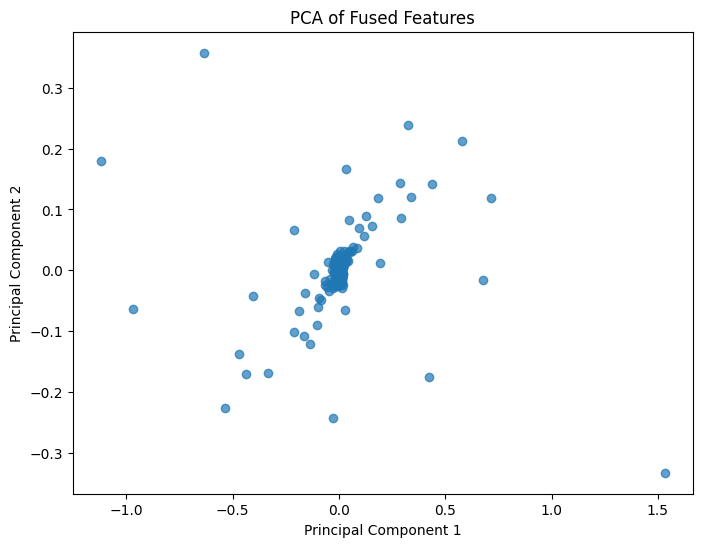

Epoch 1/40 - LSTM Loss: 0.0001


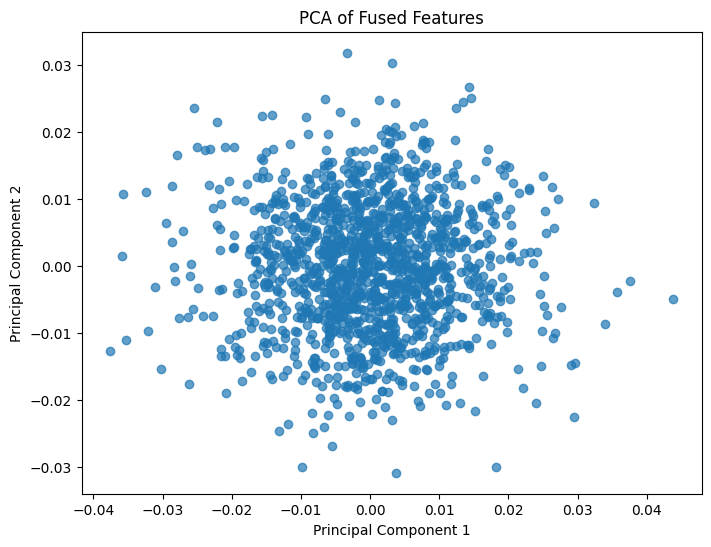

Epoch 2/40 - LSTM Loss: 0.0000


KeyboardInterrupt: 

In [144]:

# Main Training Loop
def main_training(num_epochs=40, batch_size=1, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Optimizer
    optimizer = Adam(
        [param for part in model.values() for param in part.parameters()],
        lr=learning_rate,
    )

    # Load Data

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training Loop
    train_lstm_feature_fusion(model, train_loader, optimizer, device,num_epochs)
        
    # print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training Complete!")

    # Testing
    test_loss = evaluate(model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f}")
    
# Run the training
main_training()

In [109]:
torch.save({name: part.state_dict() for name, part in model.items()}, "trained_model.pth")



In [114]:
def generate_feature_fusion_from_text(model, text_input, device):
    """
    Generate feature fusion output using only text embeddings.

    Args:
        model (dict): Trained model.
        text_input (Tensor): Tokenized text input [batch_size, seq_len, embed_dim].
        device: Torch device (cuda/cpu).

    Returns:
        Predicted feature fusion output [batch_size, fused_dim].
    """
    model['lstm_feature_fusion'].eval()
    model['text_encoder'].eval()
    model['graph_encoder'].eval()
    model['feature_fusion'].eval()
    with torch.no_grad():
        text_embeddings = model['text_encoder'](text_input.unsqueeze(1))  # [batch_size, seq_len, embed_dim]
        predicted_fused_features = model['lstm_feature_fusion'](text_embeddings)  # [batch_size, fused_dim]
    
    return predicted_fused_features

inputs = tokenizer("The 3D model features a central fuselage with two horizontal wings mounted symmetrically above, and a single vertical stabilizer at the rear. It includes a circular propeller at the front and two elongated landing gear elements beneath, creating a compact aircraft shape.", return_tensors="pt", padding=True, truncation=True, max_length=32)
input_ids = inputs["input_ids"].to(dtype=torch.long)  # Ensure integer token IDs and move to device

with torch.no_grad():
    outputs = bert_model(input_ids.to(device))  # Ensure input is on the correct device
text_label_embedding = outputs.last_hidden_state.to(device)  # Pool the embeddings and move to device
print(text_label_embedding.shape)
pooled_text_label = text_label_embedding.mean(dim=1)
ff=generate_feature_fusion_from_text(model,pooled_text_label,device)
print(ff.size())

torch.Size([1, 32, 768])
torch.Size([1, 128])


In [88]:
# def generate_graph_from_bert(model, bert_embedding, device):
#     """
#     Generate a graph using BERT embeddings and the codebook.
    
#     Args:
#         model: Dictionary containing the model components.
#         bert_embedding: Tensor of shape [1, embedding_dim] from BERT.
#         device: Device to run the model on (CPU or GPU).
#     """
#     # Move BERT embedding to the correct device
#     bert_embedding = bert_embedding.to(device)  # Shape: [1, embedding_dim]

#     # Quantize the BERT embedding
#     with torch.no_grad():
#         z_q, _ = model['vector_quantizer'](bert_embedding)  # Quantized representation

#     # Decode the quantized embeddings to generate graph
#     reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_q)
#     print("Reconstructed Nodes:", reconstructed_nodes)
#     print("Reconstructed Adjacency Matrix:", reconstructed_adj)

#     # Visualize the generated graph
#     visualize_3d(reconstructed_nodes, reconstructed_adj)

# # Example Usage
# generate_graph_from_bert(model, text_label_embedding, device)


In [116]:
with torch.no_grad():
    model['vector_quantizer'].eval()
    model['graph_decoder'].eval()
    z_latent,_ = model['vector_quantizer'](ff)
    print(z_latent.size)
    new_nodes, new_adj = model['graph_decoder'](z_latent,2479)    
    print("Generated Nodes:", new_nodes.shape)
    print("Generated Adjacency Matrix:", new_adj.shape)

<built-in method size of Tensor object at 0x000001EAF598B890>
Generated Nodes: torch.Size([2479, 3])
Generated Adjacency Matrix: torch.Size([2479, 2479])


In [117]:
import torch
import numpy as np

def adjacency_matrix_to_edge_list(adj_matrix):
    """
    Convert an adjacency matrix to an edge list.

    Args:
        adj_matrix (torch.Tensor or np.ndarray): Adjacency matrix of shape [num_nodes, num_nodes].

    Returns:
        edge_list (np.ndarray): Edge list of shape [2, num_edges].
    """
    adj_matrix = adj_matrix.cpu().numpy() if isinstance(adj_matrix, torch.Tensor) else adj_matrix
    edge_list = np.array(np.nonzero(adj_matrix))  # Extract non-zero entries (edges)
    return edge_list  # Shape: [2, num_edges]

# Convert adjacency matrix to edge list
edge_list = adjacency_matrix_to_edge_list(new_adj)

# Visualize the graph
visualize_3d(new_nodes.cpu().numpy(), edge_list)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001EAF4CF7600> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001EAF4D268E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
visualize_3d(vertices_np, edges_np)